### Import

In [47]:
from transformers import pipeline
import pandas as pd
import numpy as np
from tqdm import tqdm
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

python(88293) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


In [11]:
data = pd.read_csv("../data/data_small.csv")
data = data.drop(columns = ["Unnamed: 0", "dataset", "source"])
data

,text,logical_fallacies
0,Testing on animals could save the life of you ...,appeal_to_emotion
1,"I remember when China took over Hong Kong, I r...",none
2,": The only ""Light at the End of the Tunnel"", i...",appeal_to_emotion
3,So you only believe there are two ways to run ...,none
4,Keep things the way they are or change them co...,false_dilemma
...,...,...
4995,tesforArgumentforAr,none
4996,"Either you support all of my ideas, or you don...",false_dilemma
4997,These former Soviet countries are all the same...,faulty_generalization
4998,: Revealed: leader of group peddling bleach as...,none


### Preparing the pipeline

In [13]:
classifier = pipeline("zero-shot-classification",device = 0)

No model was supplied, defaulted to facebook/bart-large-mnli and revision d7645e1 (https://huggingface.co/facebook/bart-large-mnli).
Using a pipeline without specifying a model name and revision in production is not recommended.
Device set to use mps:0


### Making Predictions

In [54]:
category_map = {
    'appeal_to_emotion': 'appeal to emotion',
    'faulty_generalization': 'faulty generalization',
    'ad_hominem': 'ad hominem',
    'false_dilemma': 'false dilemma',
    'appeal_to_authority': 'appeal to authority',
    'none': 'none'
}

In [22]:
category_map_def = {
    'appeal_to_emotion': 'This fallacy occurs when emotion is used to support an argument, such as pity, fear, anger, etc.',
    'faulty_generalization': 'This fallacy occurs when an argument assumes something is true for a large population without having a large enough sample. A kind of overgeneralization.',
    'ad_hominem': 'This fallacy occurs when the speaker is attacking the other person or some aspect of them rather than addressing the argument itself.',
    'false_dilemma': 'This fallacy occurs when only two options are presented in an argument, even though more options may exist. A case of “either this or that”.',
    'appeal_to_authority': 'This fallacy occurs when an argument relies on the opinion or endorsement of an authority figure who may not have relevant expertise or whose expertise is questionable. When applicable, a scientific consensus is not an appeal to authority.',
    'none': 'There are no fallacies in this text!'
}

In [57]:
candidate_labels = list(category_map.values())
predictedCategories = []
trueCategories = []
for i in tqdm(range(len(data))):
#for i in tqdm(range(100)):
    text = data.iloc[i,]['text']
    cat = [data.iloc[i,]['logical_fallacies']]
    res = classifier(text, candidate_labels, multi_label=False)
    labels = res['labels'] 
    scores = res['scores'] #extracting the scores associated with the labels
    res_dict = {label : score for label,score in zip(labels, scores)}
    sorted_dict = dict(sorted(res_dict.items(), key=lambda x:x[1],reverse = True)) #sorting the dictionary of labels in descending order based on their score
    categories  = next(k for i, (k,v) in enumerate(sorted_dict.items()))

    predictedCategories.append(categories)
    trueCats = [category_map[x] for x in cat]
    trueCategories.append(trueCats)

100%|██████████| 5000/5000 [51:16<00:00,  1.63it/s]  


### Classification Report

In [58]:
print(classification_report(trueCategories, predictedCategories))

                       precision    recall  f1-score   support

           ad hominem       0.15      0.19      0.17       498
  appeal to authority       0.11      0.74      0.19       328
    appeal to emotion       0.29      0.23      0.26       754
        false dilemma       0.09      0.09      0.09       439
faulty generalization       0.13      0.19      0.15       635
                 none       0.39      0.02      0.03      2346

             accuracy                           0.14      5000
            macro avg       0.19      0.24      0.15      5000
         weighted avg       0.27      0.14      0.11      5000



In [33]:
sequence_to_classify = data.iloc[0,]['text']
print("true_label", data.iloc[0,]['logical_fallacies'])
candidate_labels = ['ad_hominem', 'appeal_to_authority', 'appeal_to_emotion', 'false_dilemma', 'faulty_generalization', 'none']
classifier(sequence_to_classify, candidate_labels)

true_label appeal_to_emotion


{'sequence': 'Testing on animals could save the life of you or a family member. Do you really think the life of your child is less important than a mouse?',
 'labels': ['appeal_to_emotion',
  'appeal_to_authority',
  'false_dilemma',
  'ad_hominem',
  'faulty_generalization',
  'none'],
 'scores': [0.3103480339050293,
  0.2585570514202118,
  0.17311961948871613,
  0.15250879526138306,
  0.07671978324651718,
  0.028746716678142548]}

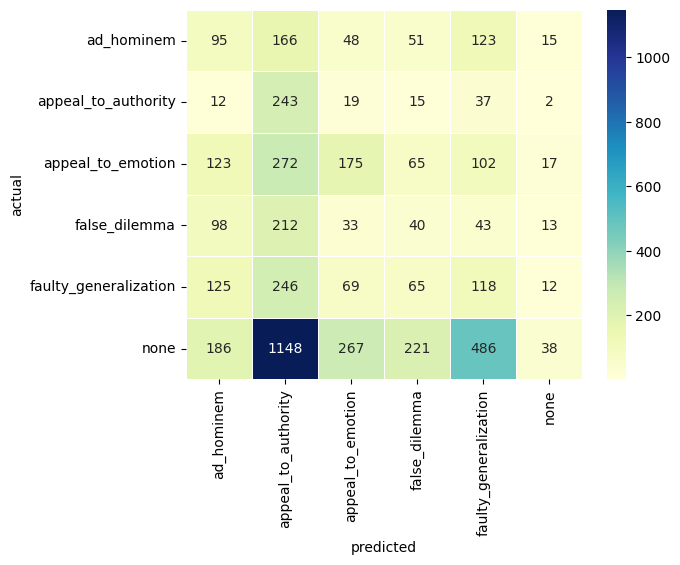

In [59]:
cm = confusion_matrix(trueCategories, predictedCategories)
labels = sorted(data['logical_fallacies'].unique())

sns.heatmap(cm, cmap='YlGnBu', annot=True, fmt='d', linewidths=.5, xticklabels=labels, yticklabels=labels);
plt.xlabel("predicted")
plt.ylabel("actual")

plt.show()